In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os

## 파라미터 설정

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [5]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':30,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE': 64,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'train_magnification':20,
    'test_magnification':20,
}

In [6]:
pth_name=f"/data/pthfile{CFG['train_magnification']}X_e{CFG['EPOCHS']}.pth"
train_data_path = f"/data/PDA_mask_img/{CFG['train_magnification']}X/**/*.png"
test_data_path = f"/data/PDA_mask_img/{CFG['test_magnification']}X/**/*.png"
output_name = f"{CFG['train_magnification']}_{CFG['test_magnification']}_{CFG['EPOCHS']}"
output_path = f"/data/output/output_{output_name}"

print(f"pth_name:{pth_name}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")
print(f"output_path:{output_path}")

pth_name:/data/pthfile20X_e30.pth
train_data_path:/data/PDA_mask_img/20X/**/*.png
test_data_path:/data/PDA_mask_img/20X/**/*.png
output_path:/data/output/output_20_20_30


In [7]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [8]:
train_path_list = sorted(glob.glob(train_data_path))
train_path_list[:10]

[]

In [9]:
test_path_list = sorted(glob.glob(test_data_path))
test_path_list[:10]

[]

In [10]:
# train data path
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:10]

[]

In [11]:
train_img_path[:10]

[]

In [12]:
# test data path
test_mask_path = test_path_list[0::2]
test_img_path = test_path_list[1::2]
test_mask_path[:10]

[]

In [13]:
test_img_path[:10]

[]

In [14]:
annotation = Image.open(train_mask_path[0])
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

IndexError: list index out of range

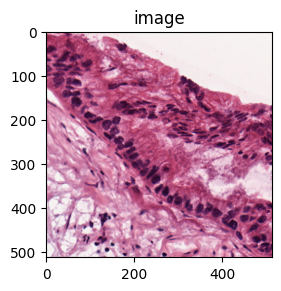

In [ ]:
image = Image.open(train_img_path[0])
plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)


In [ ]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, train = True, img_transform = None, mask_transform = None):
        self.images = img_path
        self.annotations = mask_path
        
        n_samples =  len(self.images)
        
        # 데이터 미리 섞어줌
        np.random.seed(CFG['SEED'])
        idxs = np.random.permutation(range(n_samples))
        
        self.images = np.array(self.images)[idxs]
        self.annotations = np.array(self.annotations)[idxs]
        
        # 학습용 or 평가용
        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)):]

        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]

        self.train = train
        self.img_transform = img_transform
        self.mask_transform = mask_transform


    def __len__(self):
        if self.train:
            return len(self.X_train) # 학습용 데이터셋 길이
        else:
            return len(self.X_test) # 평가용 데이터셋 길이
        
    
    def __getitem__(self, i):
        if self.train:  # 학습용 데이터
            X_train = Image.open(self.X_train[i])
            X_train = self.img_transform(X_train)
            Y_train = Image.open(self.Y_train[i]).convert('L')
            Y_train = self.mask_transform(Y_train)

            return X_train, Y_train
        
        else:  # 평가용 데이터
            X_test = Image.open(self.X_test[i])
            X_test = self.img_transform(X_test)
            Y_test = Image.open(self.Y_test[i]).convert('L')
            Y_test = self.mask_transform(Y_test)

            return X_test, Y_test

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

## 데이터 불러오기

In [ ]:
mask_transform = Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                    ToTensor()])

# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                 mask_path = train_mask_path,
                 mask_transform = mask_transform,
                 img_transform = mask_transform)

In [ ]:
img_transform = {
    'train': Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=CFG['MEAN'], std = CFG['STD']),
                      RandomHorizontalFlip()]),
    'test' : Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=CFG['MEAN'], std = CFG['STD'])])
}

In [ ]:
def denormalize(tensor, mean=CFG["MEAN"], std=CFG["STD"]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          mask_transform = mask_transform,
                          img_transform=img_transform['train'])
# 평가용 데이터
test_set = CustomDataset(img_path = test_img_path,
                         mask_path=test_mask_path,
                         mask_transform = mask_transform,
                         img_transform=img_transform['test'],
                         train=False)

In [ ]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
test_loader = DataLoader(test_set)

In [ ]:
print(len(train_set),len(test_set))

3514 879


In [ ]:
print(len(train_loader),len(test_loader))

55 879


## 학습

In [ ]:
model = UNet(num_classes=1).to(device)
model = nn.DataParallel(model)

optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from IPython.core.debugger import set_trace

In [ ]:
def dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
loss_meter = AverageMeter()
score_meter = AverageMeter()

In [30]:
for epoch in range(CFG["EPOCHS"]):
    
    try:
    
        loss_meter.reset()
        score_meter.reset()
        for data, label in tqdm(train_loader):
            optimizer.zero_grad()
            out = model(data.to(device))
            out = torch.squeeze(out)
            label = torch.squeeze(label).to(device)
            loss = nn.BCEWithLogitsLoss()(out, label.type(torch.FloatTensor).to(device))

            pred = torch.ge(out.sigmoid(), 0.5).float()
            score = dice_score(pred, label)

            loss_meter.update(loss.item())
            score_meter.update(score.item())

            loss.backward()
            optimizer.step()

        print(f"epoch{epoch+1} avg_loss:{loss_meter.avg} avg_dice:{score_meter.avg}")
        
    except KeyboardInterrupt:
        torch.save(model.state_dict(), pth_name)

  0%|          | 0/55 [00:00<?, ?it/s]

epoch1 avg_loss:0.48756950876929545 avg_dice:0.4392090801303552


  0%|          | 0/55 [00:00<?, ?it/s]

epoch2 avg_loss:0.36967502886598763 avg_dice:0.7294513626532121


  0%|          | 0/55 [00:00<?, ?it/s]

epoch3 avg_loss:0.3276604619893161 avg_dice:0.7653262311762029


  0%|          | 0/55 [00:00<?, ?it/s]

epoch4 avg_loss:0.290792670304125 avg_dice:0.7917233911427585


  0%|          | 0/55 [00:00<?, ?it/s]

epoch5 avg_loss:0.25951200235973704 avg_dice:0.8181500272317366


  0%|          | 0/55 [00:00<?, ?it/s]

epoch6 avg_loss:0.22481173439459368 avg_dice:0.8468274766748601


  0%|          | 0/55 [00:00<?, ?it/s]

epoch7 avg_loss:0.19414152232083406 avg_dice:0.8712493733926253


  0%|          | 0/55 [00:00<?, ?it/s]

epoch8 avg_loss:0.16866226494312286 avg_dice:0.8911817355589433


  0%|          | 0/55 [00:00<?, ?it/s]

epoch9 avg_loss:0.1487963000481779 avg_dice:0.9055434974757108


  0%|          | 0/55 [00:00<?, ?it/s]

epoch10 avg_loss:0.12808675400235436 avg_dice:0.9182996695691888


  0%|          | 0/55 [00:00<?, ?it/s]

epoch11 avg_loss:0.11267433911561966 avg_dice:0.9297159866853194


  0%|          | 0/55 [00:00<?, ?it/s]

epoch12 avg_loss:0.10801666717637669 avg_dice:0.9326875198971142


  0%|          | 0/55 [00:00<?, ?it/s]

epoch13 avg_loss:0.0932757403362881 avg_dice:0.9417408238757741


  0%|          | 0/55 [00:00<?, ?it/s]

epoch14 avg_loss:0.09094462638551538 avg_dice:0.9427864529869773


  0%|          | 0/55 [00:00<?, ?it/s]

epoch15 avg_loss:0.08562366420572454 avg_dice:0.94677983305671


  0%|          | 0/55 [00:00<?, ?it/s]

epoch16 avg_loss:0.07440109645778482 avg_dice:0.9537172165783969


  0%|          | 0/55 [00:00<?, ?it/s]

epoch17 avg_loss:0.06842695196921175 avg_dice:0.9571210698647933


  0%|          | 0/55 [00:00<?, ?it/s]

epoch18 avg_loss:0.061799988015131514 avg_dice:0.9610338720408353


  0%|          | 0/55 [00:00<?, ?it/s]

epoch19 avg_loss:0.060891429741274226 avg_dice:0.9618001222610474


  0%|          | 0/55 [00:00<?, ?it/s]

epoch20 avg_loss:0.06350614320148121 avg_dice:0.959751575643366


  0%|          | 0/55 [00:00<?, ?it/s]

epoch21 avg_loss:0.05619482906027274 avg_dice:0.9645346522331237


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]


KeyboardInterrupt



In [32]:
torch.save(model.state_dict(), pth_name)

## 학습된 모델 로드

In [33]:
model.load_state_dict(torch.load(pth_name, map_location=device))
model.eval() # evaluation mode
pass

## 결과 저장

In [34]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'inferno'

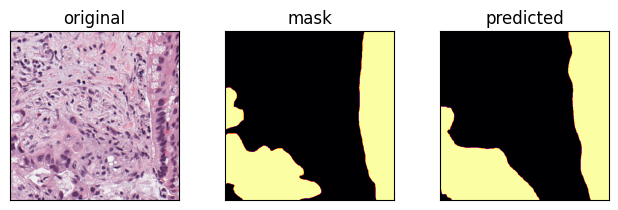

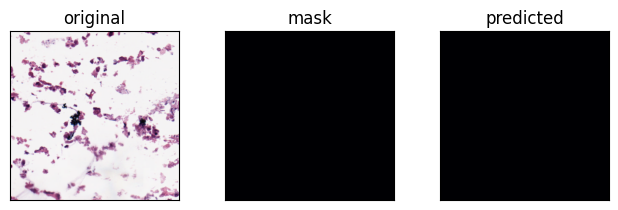

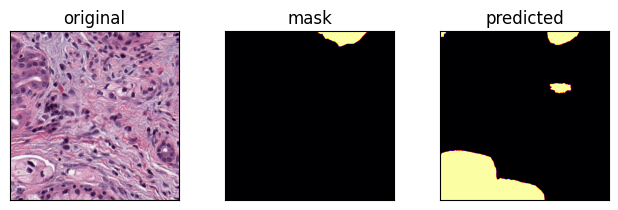

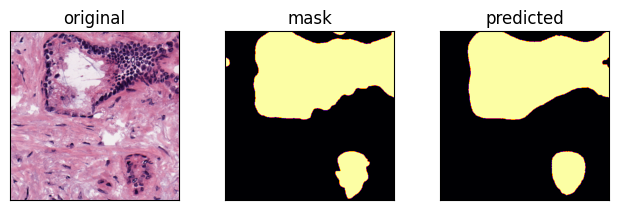

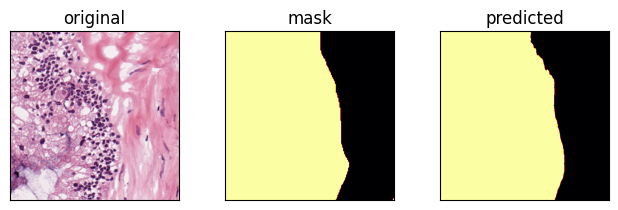

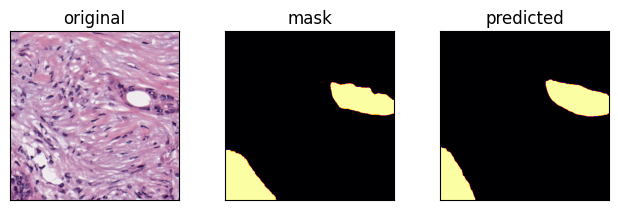

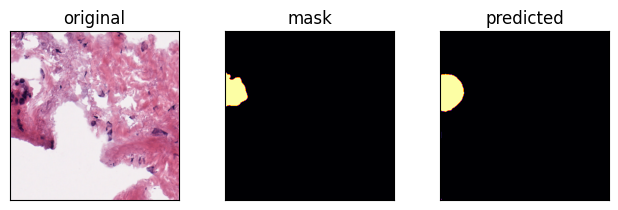

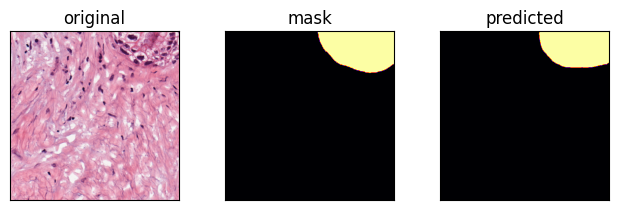

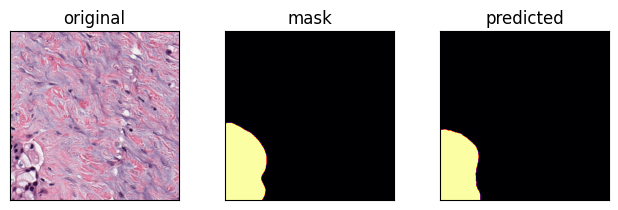

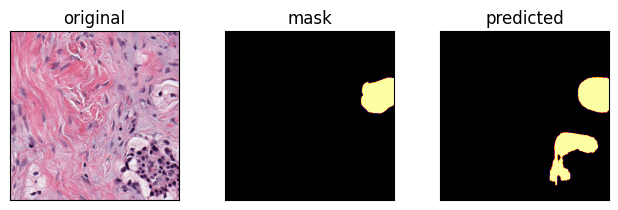

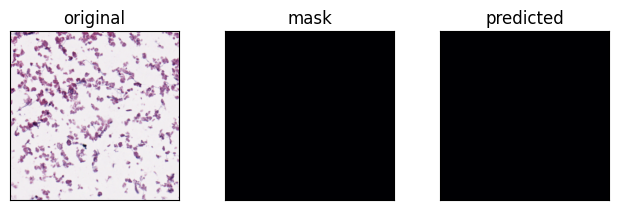

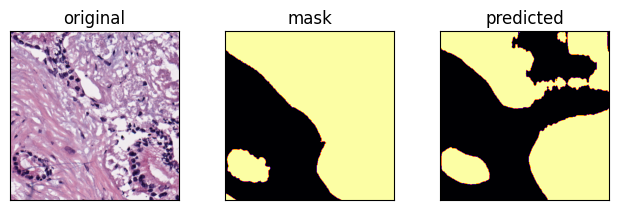

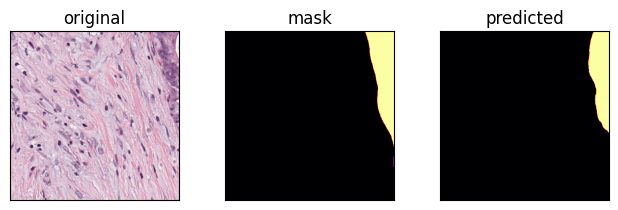

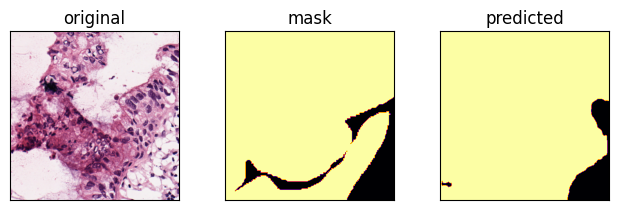

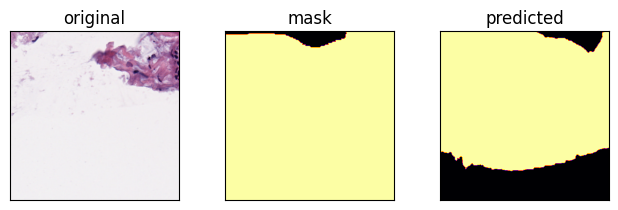

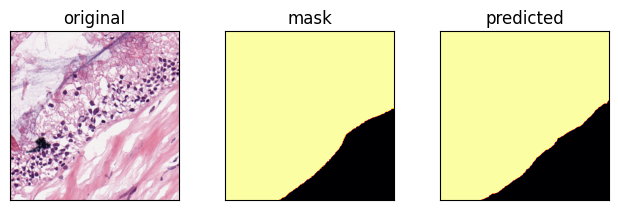

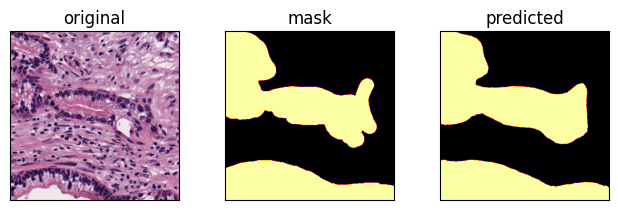

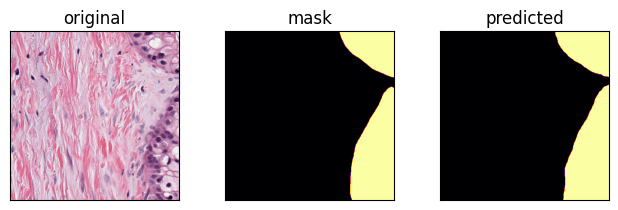

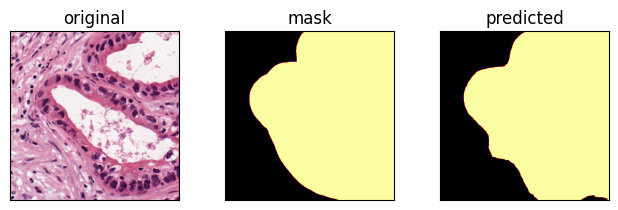

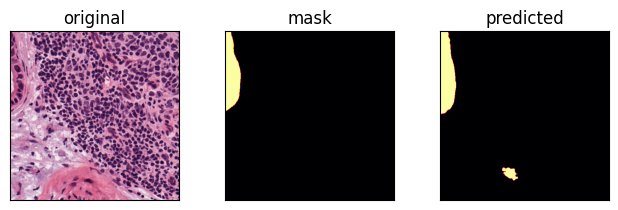

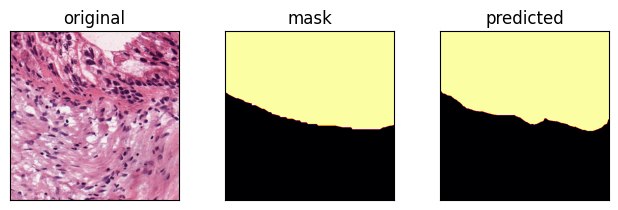

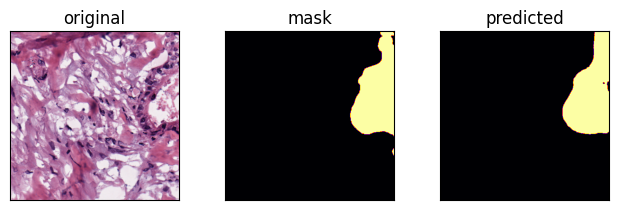

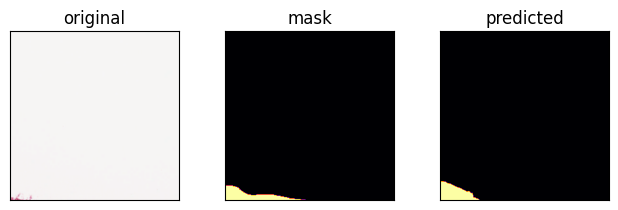

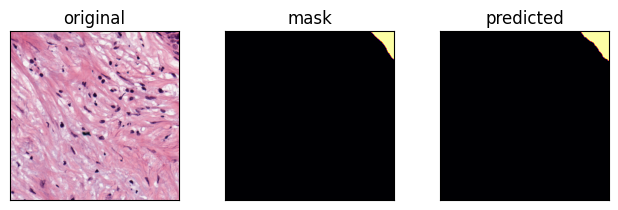

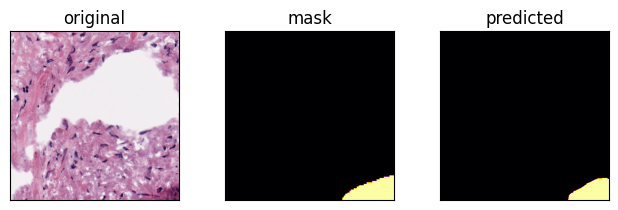

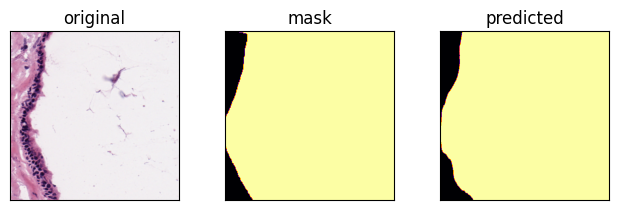

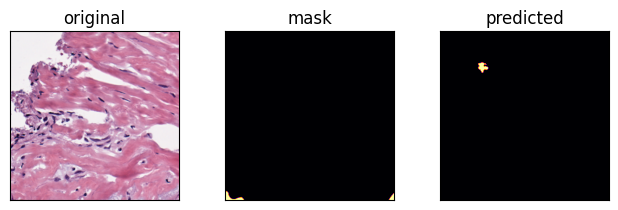

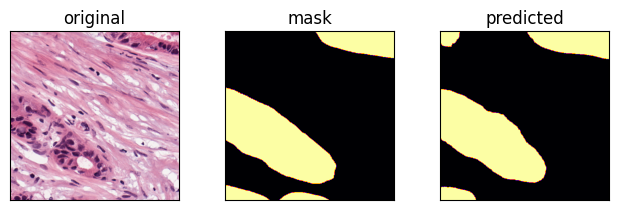

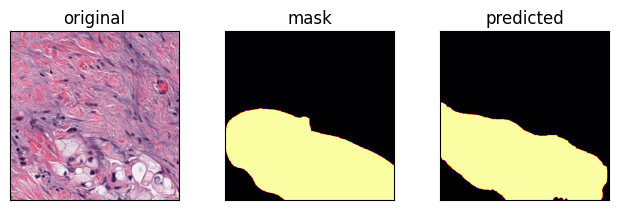

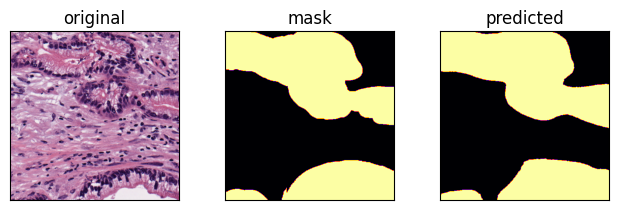

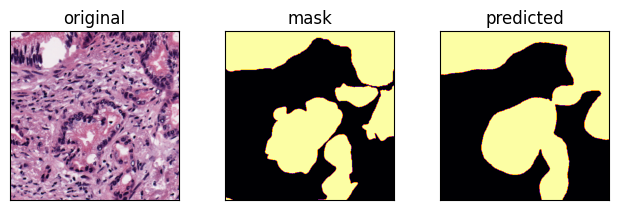

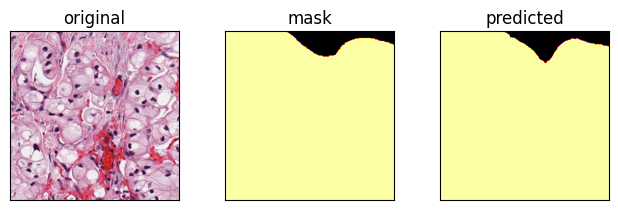

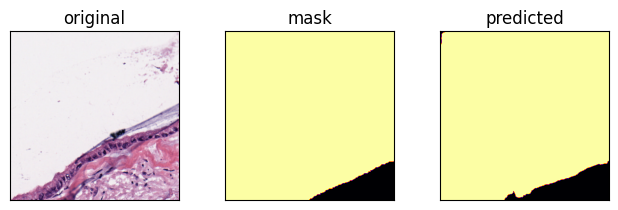

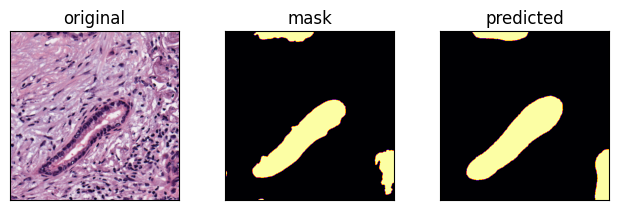

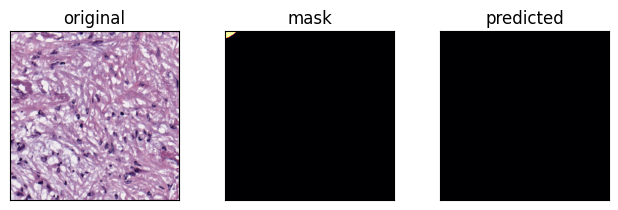

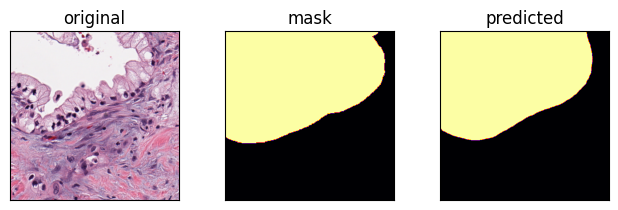

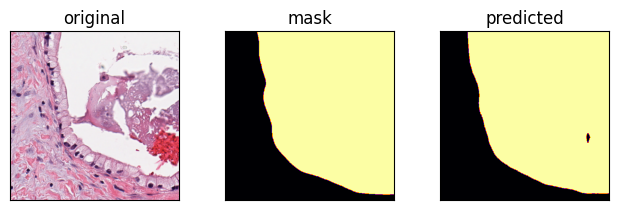

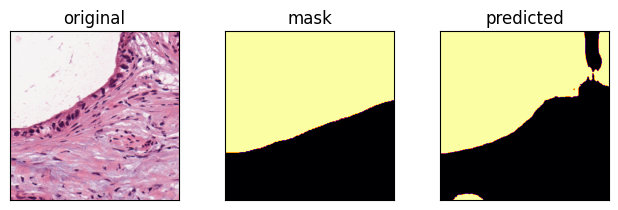

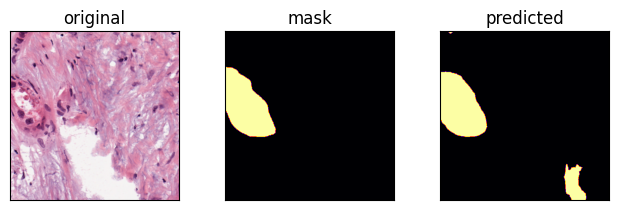

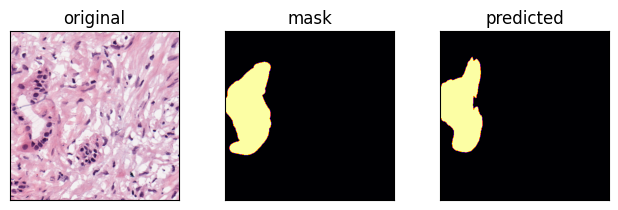

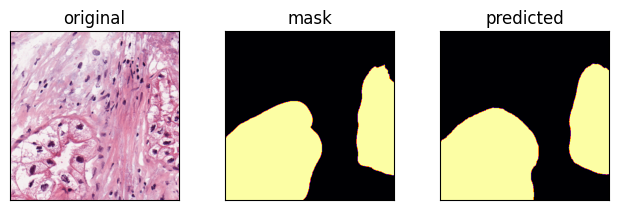

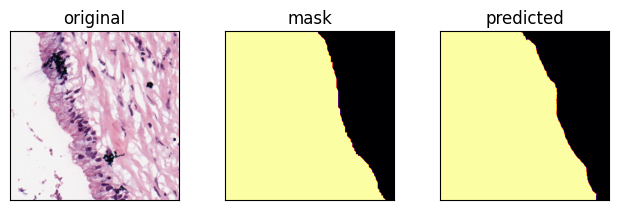

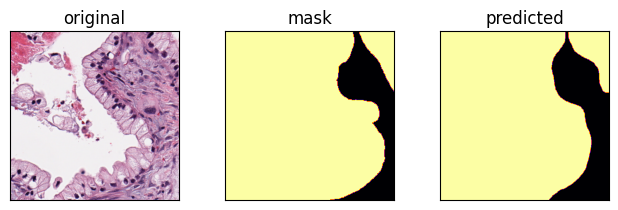

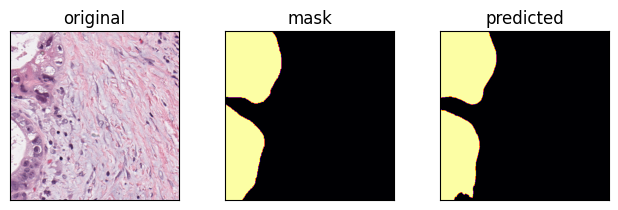

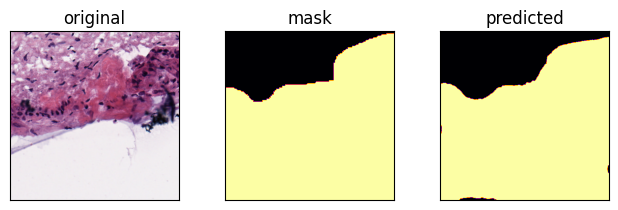

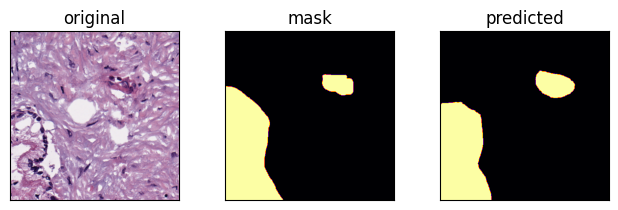

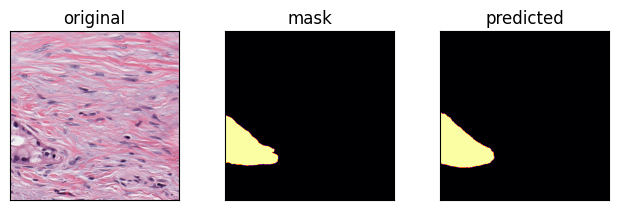

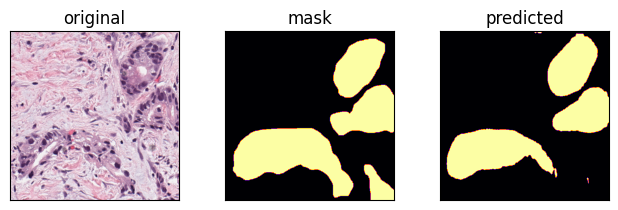

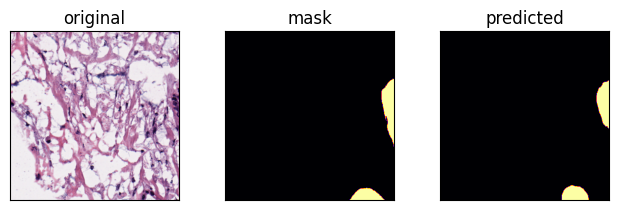

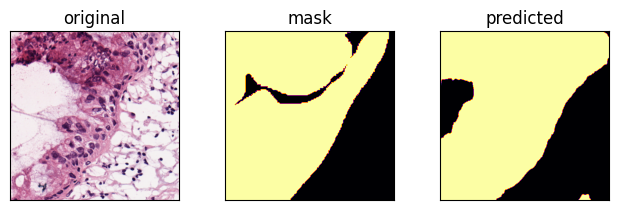

<Figure size 640x480 with 0 Axes>

In [37]:
# output_save
os.makedirs(output_path, exist_ok=True)

for i in range(50):   #len(tqdm(test_loader))
    
    data, label = test_set[i]
    with torch.no_grad():
        out = model(torch.unsqueeze(data, dim=0).to(device))
    score = torch.squeeze(out).sigmoid().to('cpu')
    pred = torch.ge(score, 0.5).float().to('cpu')
    label = torch.squeeze(label)
    
    plt.subplot(1,3,1)
    plt.title("original")
    plt.imshow(ToPILImage()(denormalize(data)))
    plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.title("mask")
    plt.imshow(label)
    plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.title("predicted")
    plt.tight_layout()
    plt.imshow(pred)
    plt.xticks([]); plt.yticks([])
    plt.show()
    plt.savefig(f'{output_path}/{output_name}_{i+1}.png')